In [1]:
# tensorflow 버전 확인
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 1.먼저 본인의 Kaggle 계정에서 API Token 을 다운받습니다.(kaggle.json)
# 2.Kaggle API를 설치합니다.
!pip install kaggle   
# 3.kaggle.json 파일을 VM에 업로드 합니다.
from google.colab import files
files.upload()

In [4]:
# 4.파일이 재대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [5]:
# 5.Kaggle API 가 Token을 사용하게 하기 위해 kaggle.json 파일을 ~/.kaggle로 이동 시킵니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# 6. Permission Warning 이 일어나지 않도록 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# dataset URL : https://www.kaggle.com/puneet6060/intel-image-classification
# 7.Kaggle 에서 intel-image-classification dataset을 다운 받기 위해 API Command 를 복사해서 가져옵니다.
!kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:14<00:00, 23.4MB/s]
100% 346M/346M [00:14<00:00, 24.9MB/s]


In [7]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('intel-image-classification.zip') as z: 
    z.extractall()

In [8]:
# 필요한 패키지와 모듈을 불러옴
from random import randint
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import load_model

In [9]:
# 저장해 뒀던 모델을 불러옵니다.
new_model = load_model('/content/gdrive/MyDrive/Intel_Image_Classification/Intel_image_classification_model.h5')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 146, 146, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 46, 46, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 44, 44, 128)       147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv5 (Conv2D)               (None, 12, 12, 256)       2

In [10]:
# label name 을 찾아 오는 함수를 정의한다.
def findKey(indices, search_value):
    for key, value in indices.items():
        if(value == search_value):
            return key
    return -1

In [11]:
# 디렉토리에서 이미지 파일들을 읽어오는 함수 정의
def get_images(directory):
    Images = []
    pred_img_cnt = 25  # 예측할 이미지를 몇개 불러 올 것인지 설정
    i = 0
    for image_file in os.listdir(directory):          # 디렉토리로부터 파일을 하나하나 불러 온다
        i += 1
        if i > pred_img_cnt: break
        else:
             image = cv2.imread(directory+r'/'+image_file) # 불러온 이미지를 openCV 로 읽어 들인다
             image = cv2.resize(image,(150,150))           # 이미지 크기 재조정
             Images.append(image)

    return Images

In [12]:
# 예측 할 이미지를 불러온다
pred_images = get_images('/content/seg_pred/seg_pred')
pred_images = np.array(pred_images) * 1./255
pred_images.shape

(25, 150, 150, 3)

In [13]:
# 예측할 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
prediction = new_model.predict(pred_images, verbose=1)

1/1 [==============================] - 15s 15s/step


In [14]:
np.argmax(prediction[0])

1

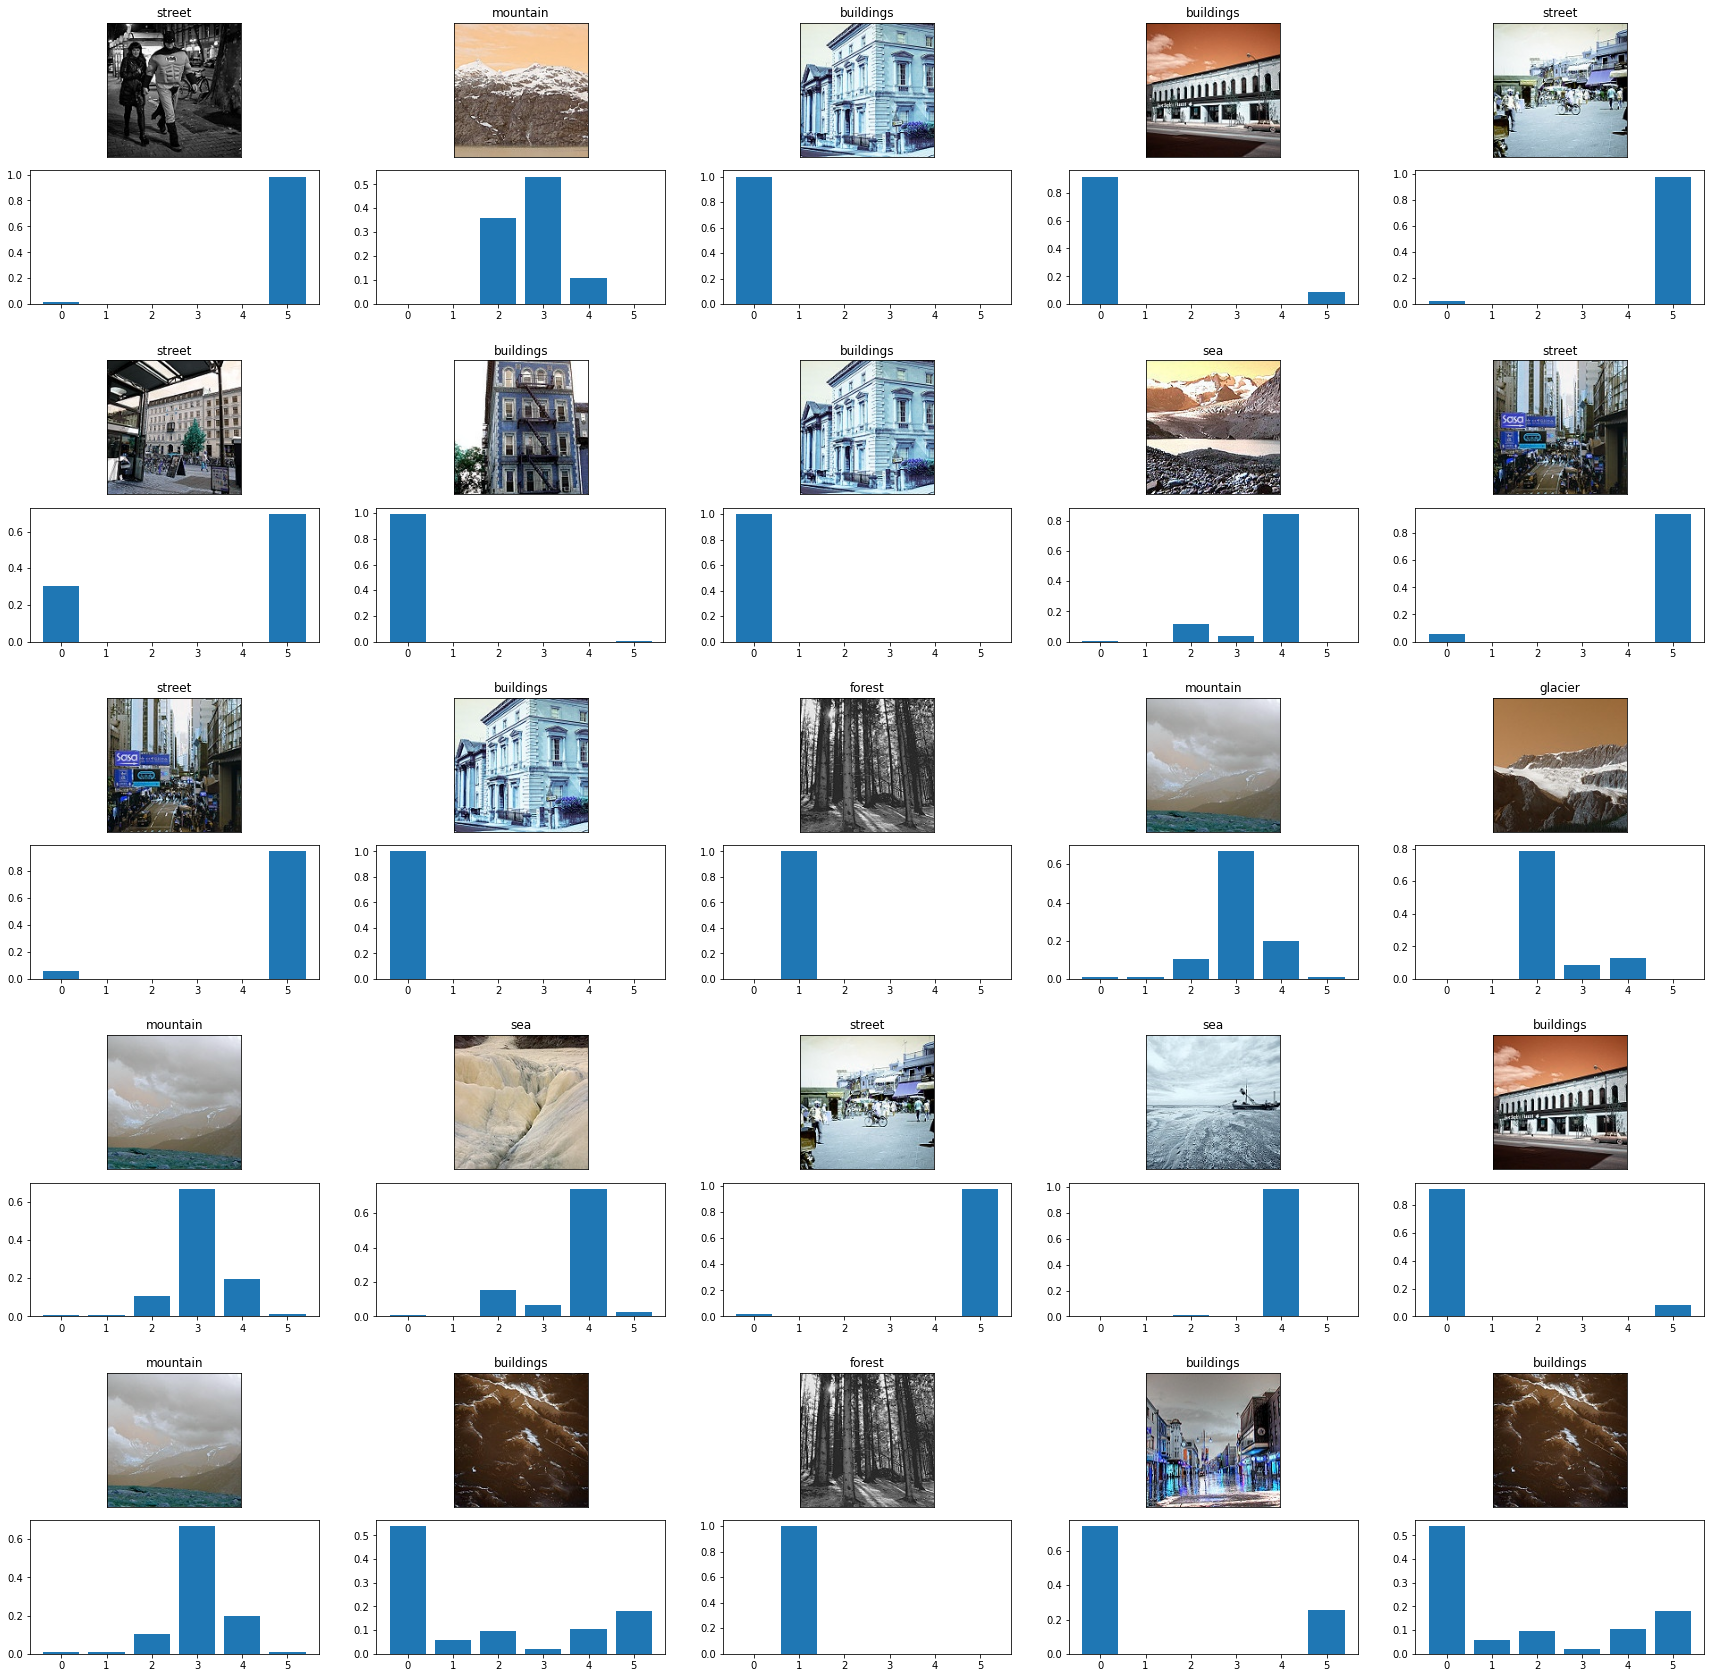

In [17]:
label_dic = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

# 예측한 결과는 아래와 같습니다. 이미지의 위에는 class label을 이미지 아래에는 확률을 나타냅니다.

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images)-1)
    pred_image = np.array([pred_images[rnd_number]])

    pred_class = findKey(label_dic, np.argmax(prediction[rnd_number]))  # 이미지의 label name 을 찾아옵니다.
    pred_prob = prediction[rnd_number].reshape(6)   # 예측된 결과(확률값)를 1차원 배열(6칸)로 reshape 합니다. 
    for j in range(2):
        if (j%2) == 0:                        # 처음에는 이미지와 title(label name) 을 보여줍니다.
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:                                 # 그다음은 확률값을 그래프 형태로 보여줍니다. 
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)

fig.show()